# Exploratory Data Analysis - Crime Data Los Angeles

This notebook is used to explore the questions for the Data Scientist Exercise in July 2020.

- How else has reported crime changed over time in the City?
- Based on your analysis, please share any changes to services, programs, or policies that the City should consider.

##  Load libraries

In [15]:
# Import libraries
import os, sys, subprocess
import json
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import dates as mdates
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

In [2]:
# load project config
terminal_call = ! git rev-parse --show-toplevel
repo_path=terminal_call[0]
project_config_path = os.path.join(repo_path,'project_config.json')

with open(project_config_path,'r') as fp: 
    project_config = json.load(fp)

In [3]:
# import custom module to look at trends
module_path = os.path.join(repo_path,project_config['project_module_relative_path'])
sys.path.append(module_path)

import trends
from trends import get_top_trends as gt
from trends import convert
from trends.convert import crime_dict, mocode_dict, violent_crime_dict # load in crime name dictionary
from importlib import reload # for updating scripts

# Load in data

In [4]:
# load in data that was collected
df = pickle.load(open("../data/crime_data.pkl", "rb"))

In [5]:
# Explore summary info
def eda(df):
    nulls = pd.DataFrame(df.isnull().sum()).T # Check for nulls
    datatypes = pd.DataFrame(df.dtypes).T # Check datatypes
    summary = pd.concat([nulls, datatypes], keys = ["nulls", "datatypes"]) # Create pandas dataframe, because I think it's easier to read
    return summary

In [6]:
eda(df)

,,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,weapon_used_cd,weapon_desc,status,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,year,mocodes_1,mocodes_2,mocodes_3
nulls,0,0,0,0,0,0,0,0,0,0,0,240361,0,208478,208527,55,228,1464999,1465000,3,0,11,2063105,2206364,2209991,0,1837686,0,0,0,0,240361,240361
datatypes,0,int64,datetime64[ns],datetime64[ns],int64,int64,object,int64,int64,int64,object,object,int64,object,object,float64,object,float64,object,object,object,float64,float64,float64,float64,object,object,float64,float64,int64,int64,object,object


## How else has reported crime changed over time in the City?

In [5]:
# Code to plot time series

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(22,10))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=5)
    plt.ylabel(ylab, fontsize=18)
    
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

In [6]:
total_crimes = pd.DataFrame(df.groupby("year").size().reset_index(name ="total_cases"))

In [7]:
total_crimes.set_index("year", inplace = True)
total_crimes.head()

,total_cases
year,
2010,200536
2011,197858
2012,200110
2013,192146
2014,194966


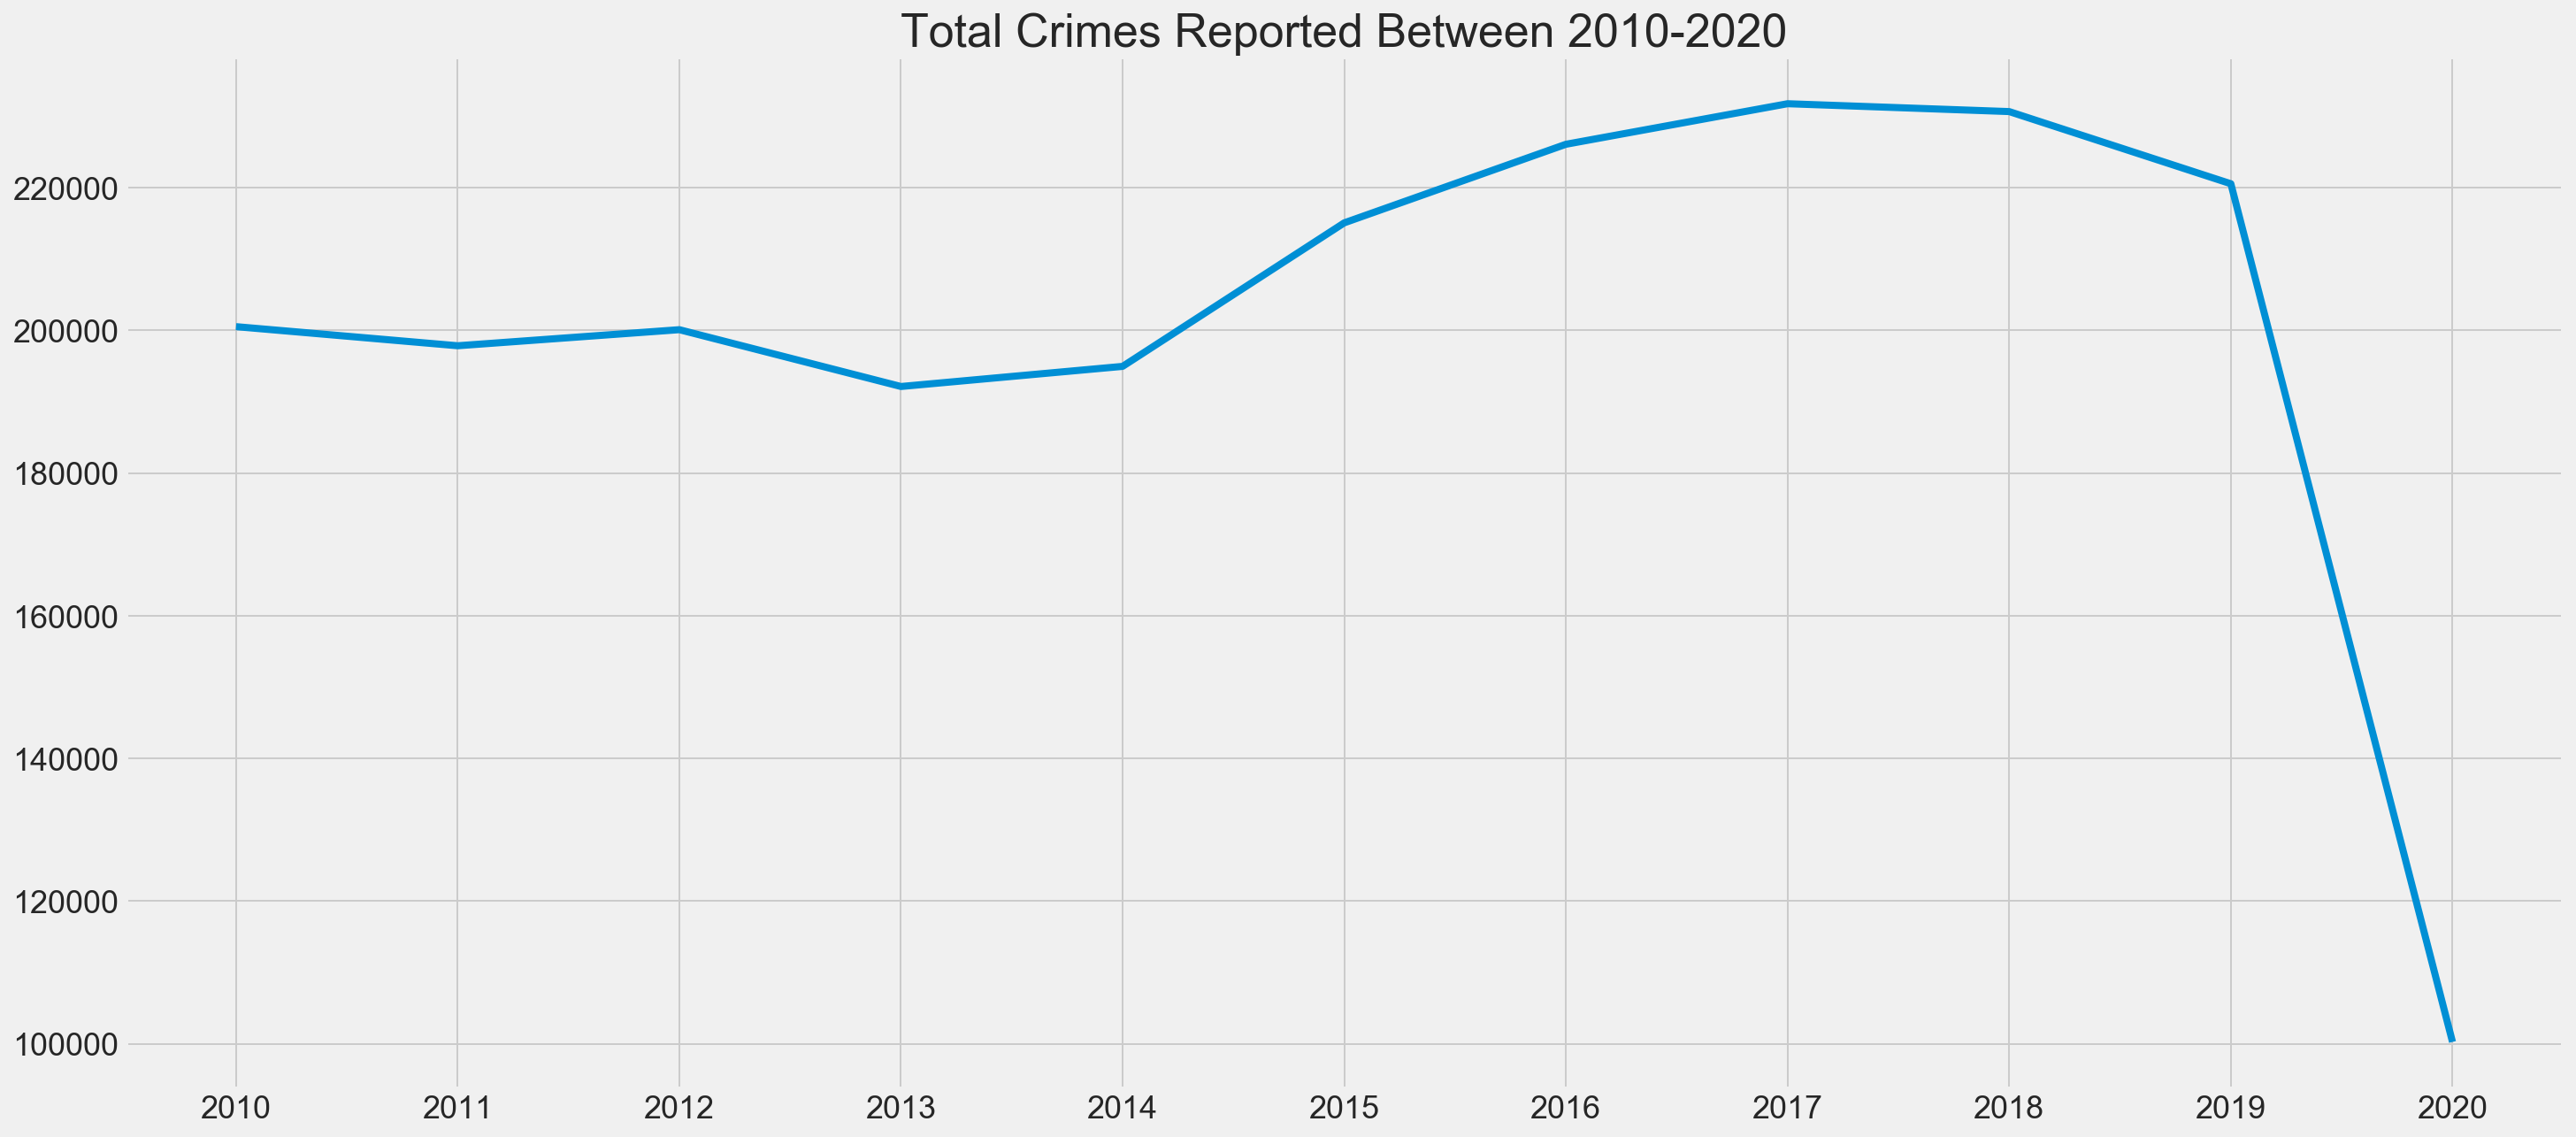

In [16]:
# Generate a time plot of our data.
plot_series(total_crimes,
            ['total_cases'],
            title = 'Total Crimes Reported Between 2010-2020',
            steps = 1);

## Calculate rolling means for daily crimes reported

In [10]:
# calculate rolling means for the number of crimes reported each day

#group by date
crimes = pd.DataFrame(df.groupby("date_rptd").size().reset_index(name ="total_cases"))
crimes.set_index("date_rptd", inplace = True)

In [11]:
# rolling mean for 1 month
crimes["rolling_mean_month"] = crimes["total_cases"].rolling(30).mean()

# quarterly rolling mean
crimes["rolling_mean_quarter"] = crimes["total_cases"].rolling(120).mean()

# annual rolling mean
crimes["rolling_mean_annual"] = crimes["total_cases"].rolling(365).mean()

In [12]:
# Code to plot time series

def plot_rolling_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size 
    fig, ax = plt.subplots(figsize=(24, 10))    
    
    # Iterate through each column name.
    for col in cols: 
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        ax.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=5)
    plt.ylabel(ylab, fontsize=18)
    
    
    # set x ticks to years
    years = mdates.YearLocator()   
    yearsFmt = mdates.DateFormatter('%Y')
    monthsFmt = mdates.DateFormatter('%b')
    months = mdates.MonthLocator((4,7,10))



    # set major ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    
    # set minor ticks
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(monthsFmt)

    # add minor ticks quarterly
    #ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.grid(which='minor', color='#cccccc', linestyle=':')
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18);

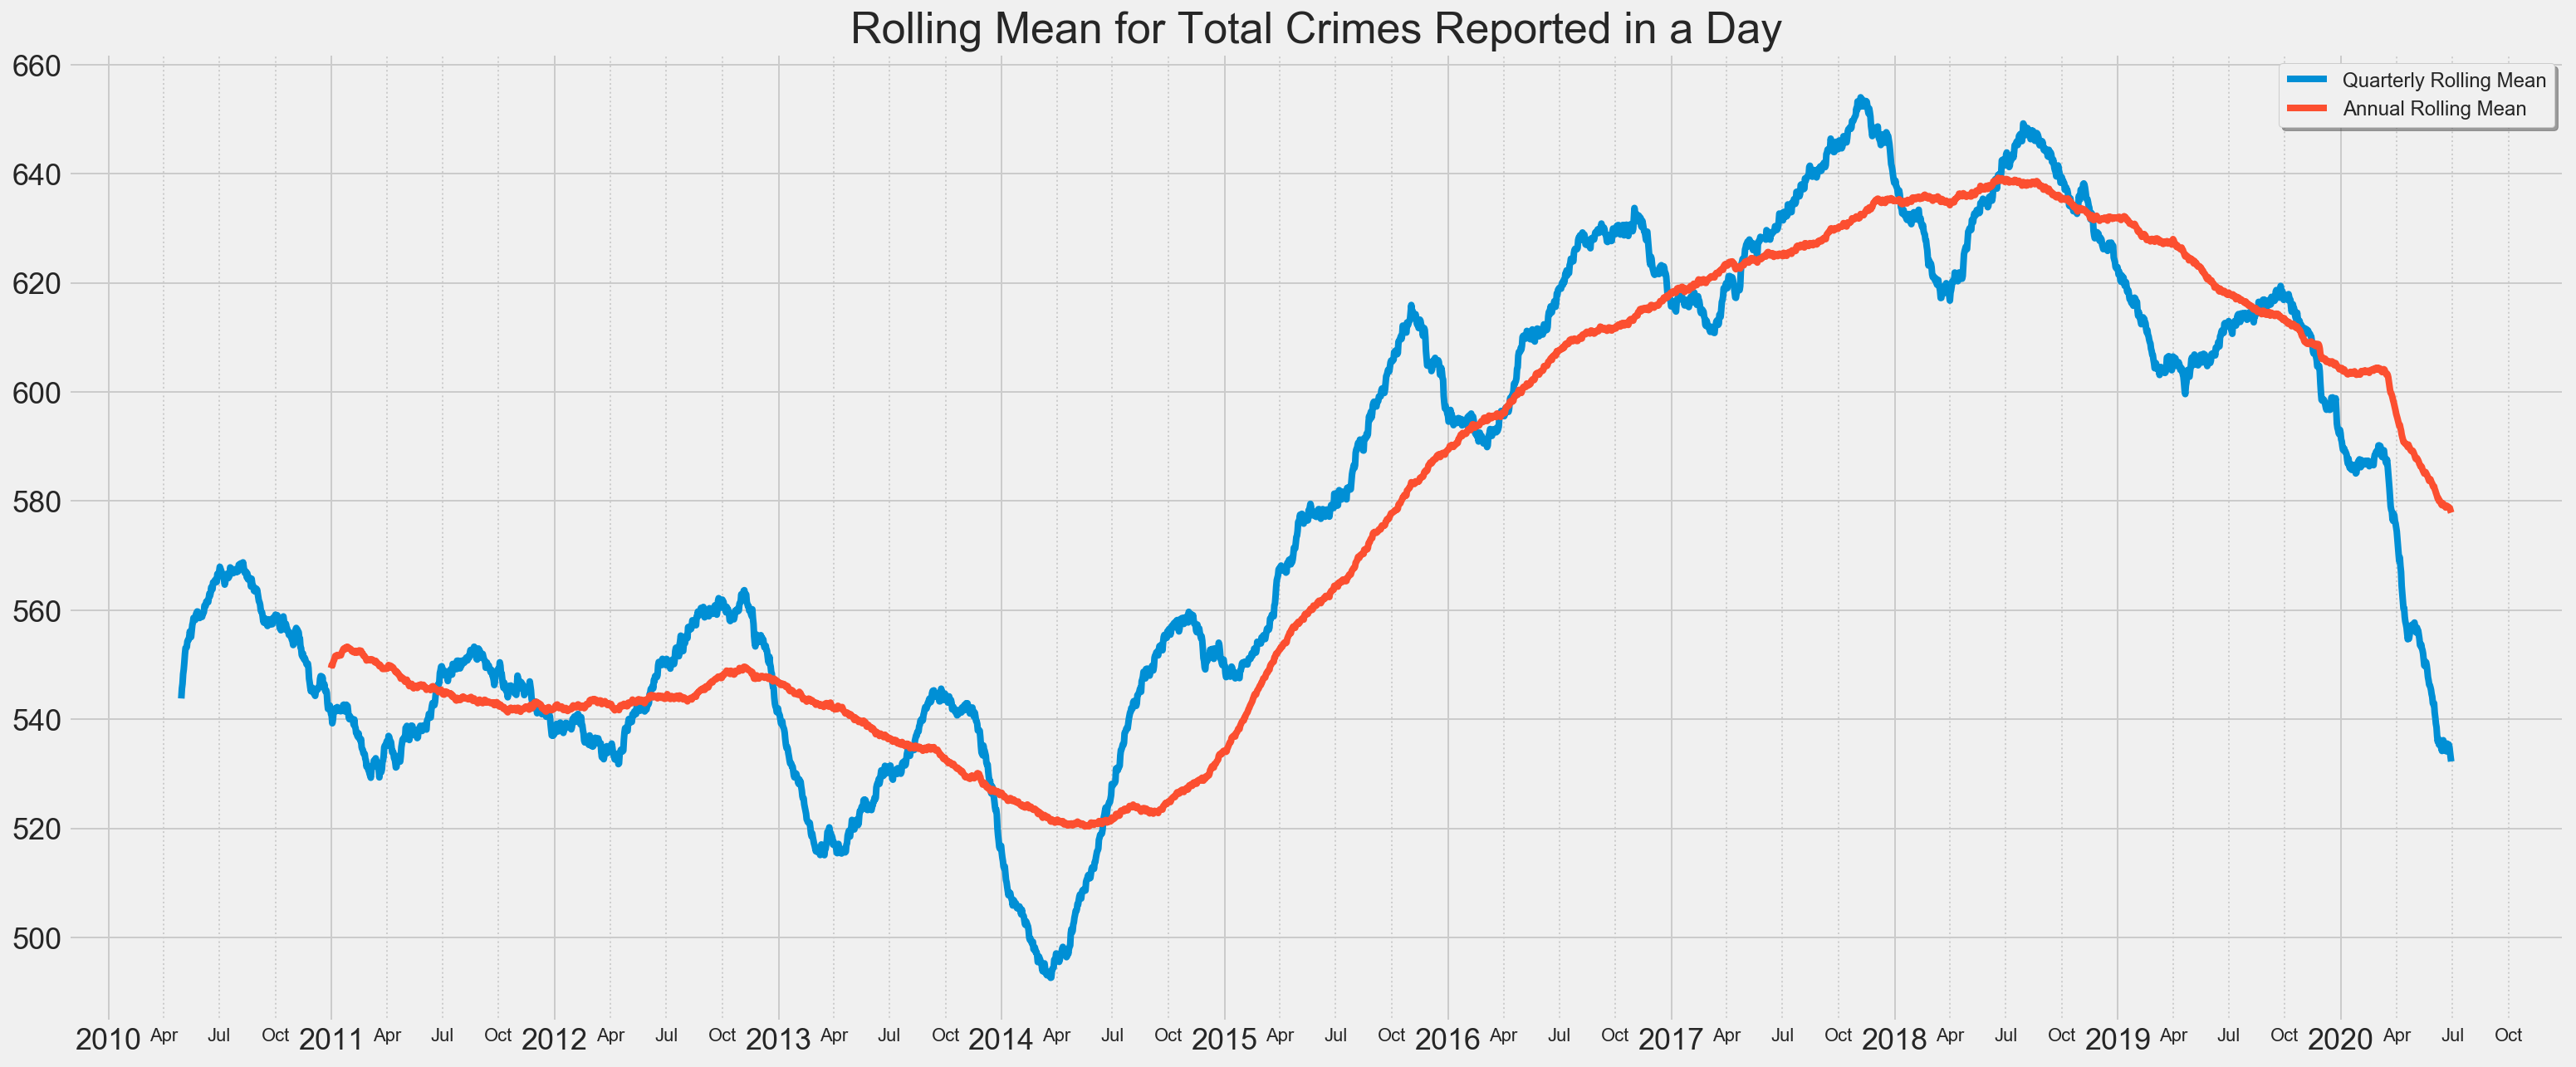

In [17]:
plot_rolling_series(crimes, ["rolling_mean_quarter", "rolling_mean_annual"], 
                    title='Rolling Mean for Total Crimes Reported in a Day')

plt.legend(labels = ["Quarterly Rolling Mean", "Annual Rolling Mean"], loc='upper right',
          fancybox=True, shadow=True, fontsize = 12);

# plt.savefig('../plots/daily_reports_rolling_means.eps', format='eps', dpi=72)

## Are the crimes getting more serious over the years?

According to the datasource, lower crime class numbers are more serious [source](https://data.lacity.org/A-Safe-City/Crime-Data-from-2020-to-Present/2nrs-mtv8). 
Looking at the UCR Crime codes [here](https://data.lacity.org/api/views/63jg-8b9z/files/fff2caac-94b0-4ae5-9ca5-d235b19e3c44?download=true&filename=UCR-COMPSTAT062618.pdf), I created a dictionary of all the violent crime codes.

In [18]:
# create a column that checks if the crime is violent
df["is_violent"]= [i in violent_crime_dict.keys() for i in df["crm_cd"]]

In [173]:
# calculate the % of violent crimes each year and area
violent_crimes = (df.groupby(["year", "area", "area_name"])["is_violent"].sum()/df.groupby(["year", "area"]).size()).reset_index(name="percent_violent")

In [176]:
# only select for year 2010 and 2020
violent_crimes = violent_crimes[(violent_crimes["year"]== 2010) | (violent_crimes["year"]== 2020)]

In [177]:
# conditional color. Color red if the % violent crime increased over the 10 years
highlight = ['#ff3700' if (violent_crimes[violent_crimes["area"] == i]["percent_violent"].values[1] > violent_crimes[violent_crimes["area"] == i]["percent_violent"].values[0]) else "#323232" for i in violent_crimes["area"]]

In [178]:
violent_crimes.head()

,year,area,area_name,percent_violent
0,2010,1,Central,0.391248
1,2010,2,Rampart,0.418766
2,2010,3,Southwest,0.362579
3,2010,4,Hollenbeck,0.348423
4,2010,5,Harbor,0.275000


In [ ]:
g = sns.FacetGrid(violent_crimes, col="area_name", col_wrap=5, height=3, sharex=False)
g = (g.map(plt.plot, "year", "percent_violent", marker=".")).set(ylim=(0,.5), yticks=[.25,.5], xlim=(2010, 2020), xticks=[2010, 2020])
#g.set_xlabels([2010,2020], fontsize=10)
g.set_ylabels("% violent crimes", fontsize=10)
g.set_xlabels("")
g.set_titles("{col_name}")
#g.set_yticklabels(labels=[.25,.5], size=10)
#g.set_xticklabels(labels = [2010,"", "", "", "", 2020], size=10);


# customize color on conditional. If the % of violent crimes has increased over the years, color red. 
for i in np.arange(0,21):
    (g.facet_axis(0,i)).get_lines()[0].set_color(highlight[i])
    

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Trend in % Violent Crimes by LAPD Area 2010-2020', fontsize=20)

#plt.savefig('../plots/violent_crimes_area.eps', format='eps', dpi=72)

Text(0.5, 0.98, 'Trend in % Violent Crimes by LAPD Area 2010-2020')

## What's the status of these crimes

In [76]:
# Checking to see what the status is of all these crimes
df["status_desc"].value_counts()

Invest Cont     1704054
Adult Other     258117 
Adult Arrest    226255 
Juv Arrest      16237  
Juv Other       5406   
UNK             35     
Name: status_desc, dtype: int64

In [319]:
# Checking to see how many reported crimes are still open per year
df[df["status"]=="IC"].groupby("year")["status"].value_counts()

year  status
2010  IC        166788
2011  IC        157188
2012  IC        150634
2013  IC        144317
2014  IC        144640
2015  IC        160863
2016  IC        171019
2017  IC        176370
2018  IC        176626
2019  IC        171131
2020  IC        84478 
Name: status, dtype: int64

In [97]:
# What's the % of cases that are still open?
open = df[df["status"] == "IC"].shape[0]/ df.shape[0]
print("{:.1%}".format(open) + " cases are still open.")

77.1% cases are still open.


In [99]:
# What's the % of cases that led to a juvenile arrest?
ja_cases = df[df["status"] == "JA"].shape[0]/ df[df["status"] != "IC"].shape[0]
print("{:.1%}".format(ja_cases) + " of all closed cases led to a juvenile arrest.")

3.2% of all closed cases led to a juvenile arrest.


## Explore cases that led to a juvenile arrest

In [100]:
# segment dataframe for only the juvenile cases
ja = df[df["status"] == "JA"]

In [107]:
# top crimes that led to a juvenile arrest
ja["crm_cd_desc"].value_counts(ascending = False).head(10)

BATTERY - SIMPLE ASSAULT                                   3101
ROBBERY                                                    2109
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             1363
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    999 
BURGLARY                                                   950 
CRIMINAL THREATS - NO WEAPON DISPLAYED                     781 
THEFT PLAIN - PETTY ($950 & UNDER)                         669 
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                   650 
VEHICLE - STOLEN                                           550 
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                   438 
Name: crm_cd_desc, dtype: int64

In [122]:
total_ja = pd.DataFrame(ja.groupby("year").size().reset_index(name ="total_cases"))
total_ja.set_index("year", inplace = True)

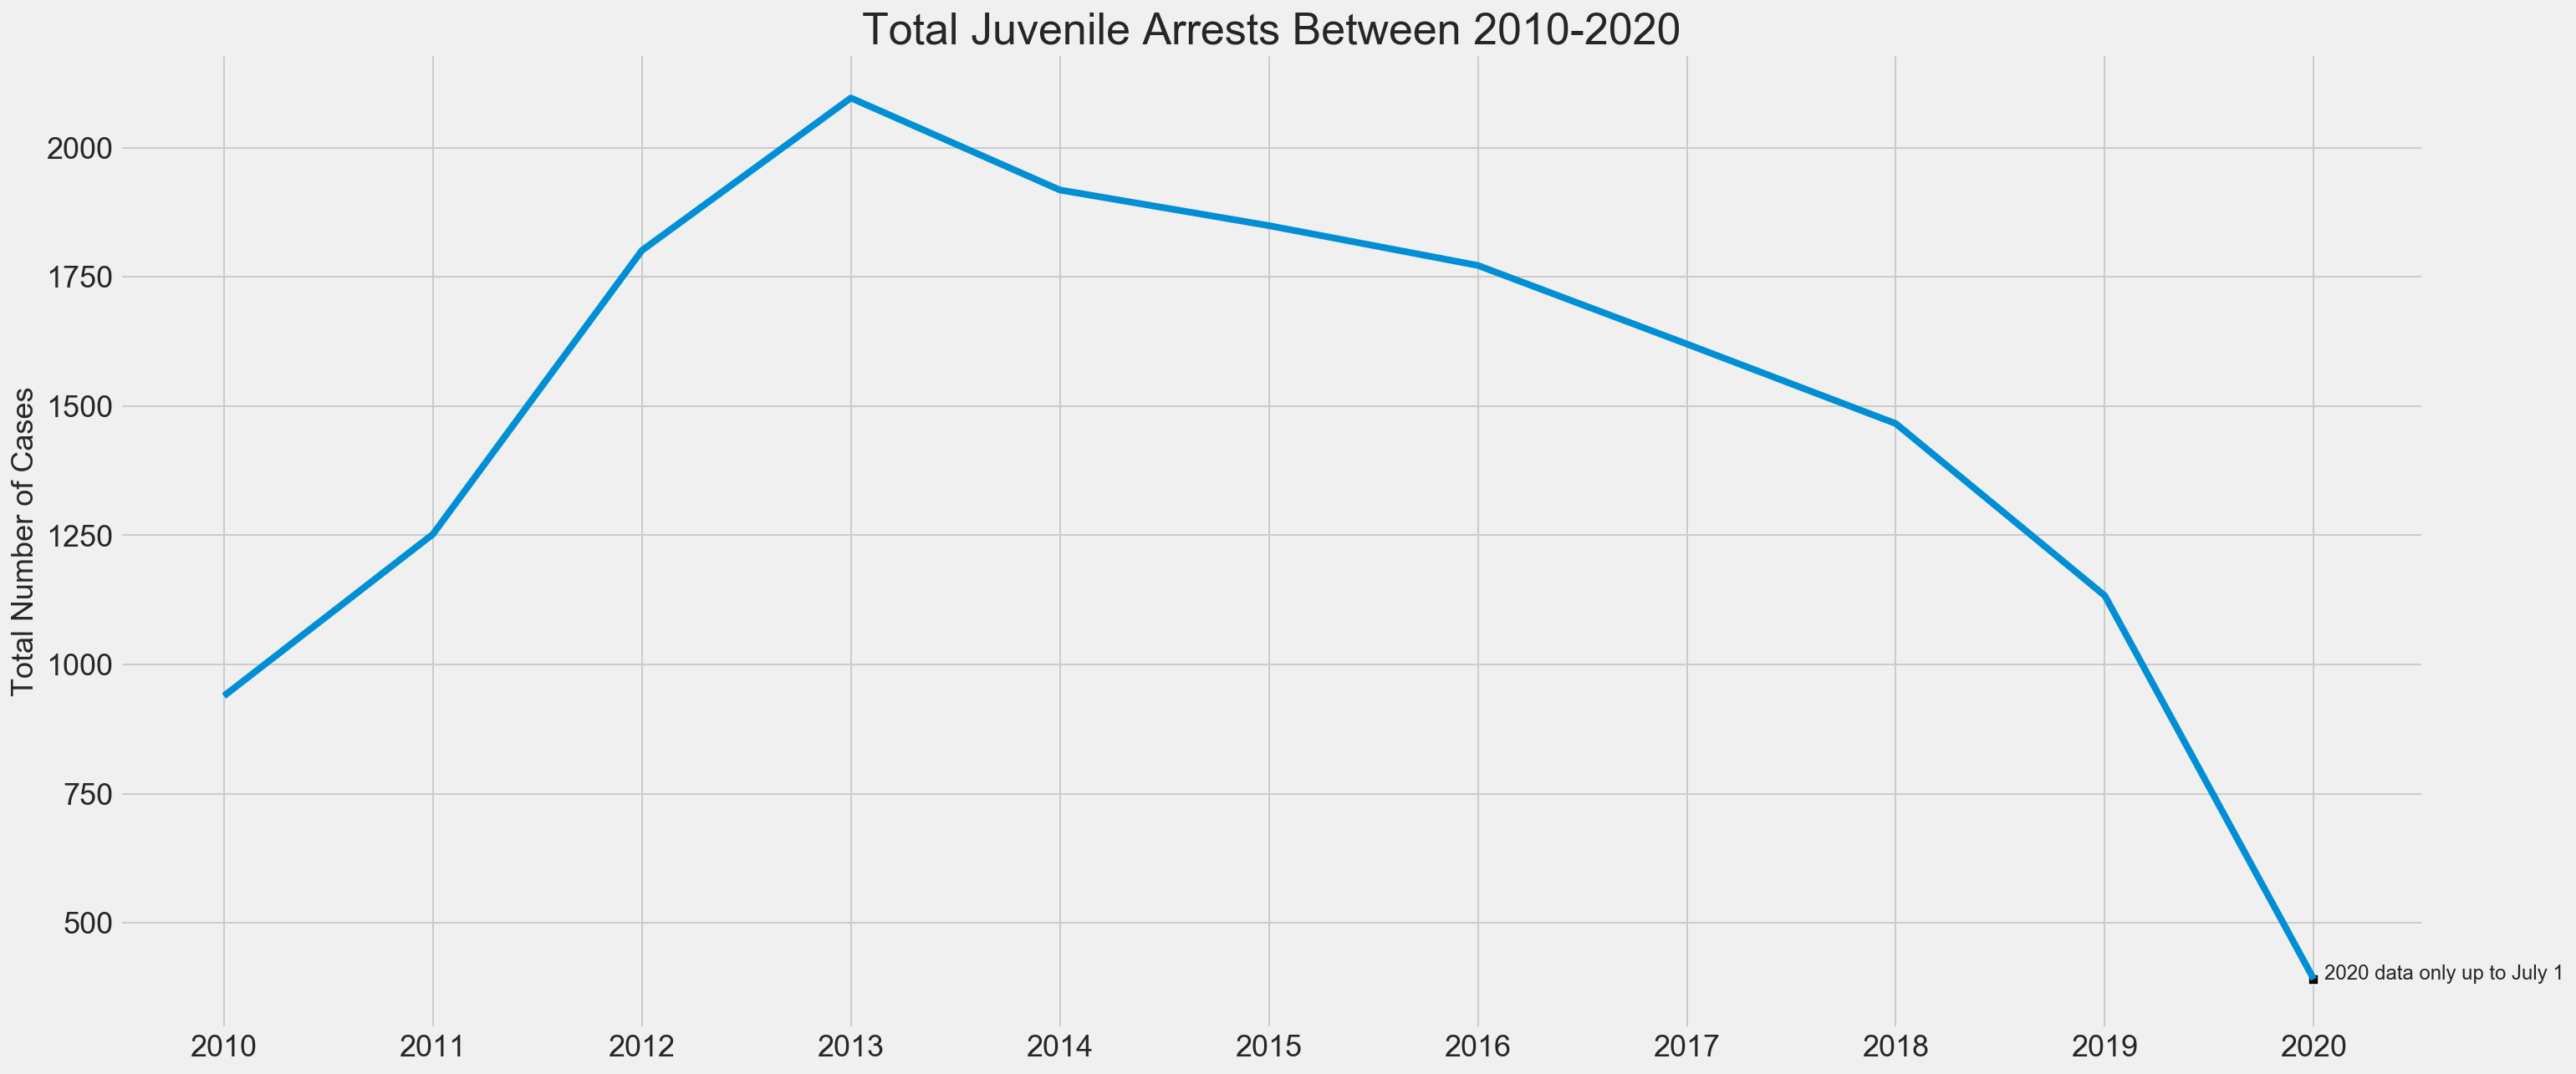

In [168]:
# Generate a time plot of our data.

plot_series(total_ja,
            ['total_cases'],
            title = 'Total Juvenile Arrests Between 2010-2020',
            steps = 1);


ax = sns.scatterplot(x=2020, y="total_cases", data=total_ja.tail(1), legend=False,
                     color = "#000000",marker = "s" )

ax.set(ylabel="Total Number of Cases")

ax.text(2020+0.05, total_ja[total_ja.index==2020]["total_cases"],
             "2020 data only up to July 1", horizontalalignment='left', size =12);

# plt.savefig('../plots/juvenile_arrests.eps', format='eps', dpi=72)